In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from time import mktime as mktime
from datetime import datetime
from shapely.geometry import Point, Polygon
from math import cos, asin, sqrt, pi
import math

const_e = 0.05
TIME_FORMAT = "%Y-%m-%d %H:%M:%S"
# calculate the distance between two points specified by latitude and longitude
# https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula
def distance(row):
  # 计算经度纬度坐标点之间距离
    lat1 = row['LAT']
    lon1 = row['LON']
    lat2 = row['LAT-shift']
    lon2 = row['LON-shift']
    r = 6371 # km
    p = pi / 180

    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))


def isValidDate(date):
    try:
        if ":" in date:
          return True
    except:
        return False

def seconds_since_midnight(row):
  dateTime = pd.to_datetime(row['BaseDateTime'],
               TIME_FORMAT)
  # print(dateTime)
  # print(type(dateTime))
  # time = pd.Series.dt.to_pydatetime(dateTime)
  time = dateTime
  new_time_1 = pd.to_datetime(time)
  new_time_2 = pd.to_datetime(time.replace(hour=0, minute=0, second=0, microsecond=0))

  s = (new_time_1 - new_time_2).total_seconds()
  return math.ceil(s)
  # print(s)
  # print(type(s))
  # d = datetime.strptime(str(row['BaseDateTime']), TIME_FORMAT)
  # return time.mktime(d.timetuple())
  # return new_time.dt.total_seconds()
  # return time - time.replace(hour=0, minute=0, second=0, microsecond=0).total_seconds()

# 统一速度单位到m/s
def get_speed(row):
  U = 0.5144
  ret = row['SOG'] * U
  return ret

def speed_Enlarge(row):
  ret = int(row['speed'] * 1000)
  return ret
def Calculated_speed_enlarge(row):
  ret = int(row['speed_calculated'] * 1000)
  return ret

def get_calculated_speed(row):
  if row['x_i'] is not None and row['x_i']:
    ret = row['distance-diff'] * 1000 / row['x_i']
  else:
    ret = None
  return ret

def get_C_p(row):
  p_w = row['cumsum_diff']
  ret = 0
  p_min = row['p_min']

  if pd.isna(p_w):
    ret = 0
  elif p_w <= 0.03:
    ret = 100
  elif (p_w - 0.03)/ p_min > 100:
    ret = 0
  else:
    ret = 100 - round((p_w - 0.03) / p_min)
  return ret


# 数据分组
def point_data_analysis(): # stop_point + track
  df = pd.read_csv('sample_data/smallaisdata.csv')
  # df['correct'] = pd.to_datetime(df['BaseDateTime'],errors='coerce')
  # 过滤器 选取相关列
  new_df = df.filter(items=['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG','COG','Heading'])
  new_df['ErrorPoint'] = False
  # 去除异常值
  cleaned_df = new_df.dropna()
  for x in cleaned_df.index:
    if cleaned_df.loc[x, "MMSI"] < 100000000 or cleaned_df.loc[x, "MMSI"] >= 1000000000:
      cleaned_df.drop(x, inplace = True)

  # print(cleaned_df)

  # 四川大学硕士论文处理方法：1 漂移点去除 + 线性插值 2 速度，方向异常算前后点平均值处理




# 下午任务： 24.01.20 切割轨道(1.21问stackoverflow)(建立新表格 依次合并)，按照5个为基准过滤(finished)，计算并移除异常轨迹点 (建立时间戳索引, 进行地图标注)
# 24.01.21 移除异常轨迹点
  df = cleaned_df.sort_values(by=['MMSI', 'BaseDateTime'])
  df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])  # Convert 'BaseDateTime' to datetime format
  df['new-time'] = df.groupby('MMSI')['BaseDateTime'].shift(-1)
  # Calculate the time difference
  s = df['BaseDateTime']

  df['Time-diff'] = (s.groupby(df['MMSI']).diff(-1)
                    .mul(-1).dt.total_seconds().div(3600)
                  )
  # Assign a group label based on the time difference



  # 使用中间需要加一段南师大硕士论文的方法检测并去除异常点异常点
  df1 = df[['LAT', 'LON']]
  # 本段加一段去除异常点的方法



  # df['GROUP'] = df.groupby('MMSI')['Time-diff'].transform(assign_group).cumsum()
  df['Group'] = df['Time-diff'].fillna(np.inf).ge(2).cumsum()
  # df = df.filter(df.groupby(['MMSI','Group']).size() < 4)

  # Drop the 'new-time' column if you don't need it anymore
  df = df.drop(columns=['new-time'])


  df = df.groupby('Group').filter(lambda x: len(x) > 4)


  # 过滤掉size小于5的点

  # v = s/t add a column    speed 这个好弄 add a column ErrorPoint(0 means ERROR 1 means right)
  # 选取矩阵[(group,TimeStamp), LAT,LON,Speed, Calculated_speed]

  # [MMSI,Group, TimeStamp, LAT, LON, Speed, Calculated_speed(s/t), ErrorPoint]

  # Time-diff -> hours , Distance -> distance function
  # 1 knots = 1.85200 kilometers per hour
  df['ErrorPoint'] = 0



  # x_i = seconds_since_midnight = (now - now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()


  # 2024.1.30日任务 将datetime数据和累加部分代码写完
  df['x_i'] = df.apply(seconds_since_midnight, axis=1) # function debug
  # print(df)
  df = df.sort_values(by=['Group', 'BaseDateTime'])
  df = df.dropna(how='any',axis=0)
  # df.to_csv('out1.csv')



  df['LAT-shift'] = (df['LAT'].groupby(df['Group']).shift(1)
                  )
  # df.groupby(['helpkey','sym']):
  df['LON-shift'] = (df['LON'].groupby(df['Group']).shift(1)
                      )
  df['distance-diff'] = df.apply(distance, axis=1) # unit: km
  # display(df)

  df['speed'] = df.apply(get_speed,axis=1) # to m/s
  # speed -> speed * 0.5144
  df['speed_calculated'] = df.apply(get_calculated_speed,axis=1)
  # df1 = df
  # df1.to_csv('out1.csv')

  df = df.drop('Time-diff', axis=1)
  df = df.drop('LAT-shift', axis=1)
  df = df.drop('LON-shift', axis=1)

  # de下bug

  # display(df)

  # 1 将df转成numpy矩阵，进行遍历并标注错误点

  # 2 计算距离之和，进行可视化matpoltlib


  # 3 根据置信度计算停留点

  #
  # df1 = df[['a', 'b']]
  # 按顺序给数据编号
  df['ID'] = df.index
  df1 = df.dropna(how='any',axis=0)
  # display(df1)

  # print(df.dtypes)



  # speed放大3倍 向下取整
  df1['speed_enlarged'] = df1.apply(speed_Enlarge,axis=1)
  # 查询同一组中的最大速度，如果计算出的速度大于平均速度，则标记为错误点。3.2任务
  # 对于标记出的错误点进行清洗，截图写入论文中

  df1['calculated_speed_enlarged'] = df1.apply(Calculated_speed_enlarge,axis=1)

  m = df1[['ID','Group','speed_enlarged', 'calculated_speed_enlarged','ErrorPoint']].to_numpy()

  # ['ID', 'Group', 'speed_enlarged','calculated_speed_enlarged','ErrorPoint']
  # 目的是更新ErrorPoint，错误点标1


  df['seconds_since_midnight'] = df.apply(seconds_since_midnight,axis = 1) # 没问题
  df['distance-diff'].fillna(0, inplace=True) # 将NaN改成0
  df['CUMSUM_C'] = df['distance-diff'].groupby(df['Group']).cumsum()

  # 横坐标和纵坐标都有了 下面作图
  # 制作曲线 求差分 通过置信确定停留点


  # df.plot(x='seconds_since_midnight', y='CUMSUM_C', style='o')

  # example_df = data_1[['record_date', 'power_consumption']].groupby('record_date').agg('sum')
  # example_df = df[['seconds_since_midnight', 'distance-diff']].groupby('Group')
  #绘图
  # example_df.plot()#这一行绘图
  # plt.xlabel('')
  # plt.ylabel('')
  # plt.show()


  # 3.10日上午确定停留点 下午进行停留点分析
  # 算出差分


  # 3.11进行停留点分析 分析相关数据 开始轨迹分析(再写一个函数)
  df['cumsum_diff'] = (df.groupby(df['Group'])['CUMSUM_C'].diff(-1)
                      .mul(-1).shift(1)
                    )
  df.loc[df['cumsum_diff'] == -0.0] = 0

  # 差分求出来了 求序列最小值
  # minimum_value = data['column_name'].min()
  # p_min是求导之后最小值
  # pw = cumsum_diff
  dfc = df.groupby('Group')['cumsum_diff']
  df['p_min'] = dfc.transform('min') # 求出p_min
  # 设置 每组的长度
  # 设置置信度C_p 写个函数分类讨论一下

  df['C_p'] = df.apply(get_C_p,axis=1)

  # 确定停留点 对标记出来的停留点进行分析
  N = 3
  df['is_parked'] = (df.groupby('Group')['C_p']
                     .transform(
                        lambda s: s.rolling(N).mean().gt(80)[::-1]
                                   .rolling(N, min_periods=1).max()
                                   .astype(int)
                     )
                   )

  # display(df.loc[(df['C_p'] >= 20) & (df['C_p'] <= 85)])




  # display(df) 展示DataFrame
  # 3.13 停留点分析

  # ArcMap分析 构建Voronoi图 把几个warning去掉
  # 可以提高的地方： 1 自己写出核密度分析 2 聚集规律圈出

  # 四川大学: 去除不连续 松散 或者纠缠的轨迹


  # 将每组保存到一个文件中 并加上名称

  # for i, g in df.groupby('Group'):
  #   g.to_csv('{}.csv'.format(i), header=False, index_label=False)
  # output_path = 'content/'
  grouped = df.groupby(df['Group'])
  for group_name, group_data in grouped:
    # 创建分组文件名
    filename = f"{group_name}.csv"
    # 将分组数据写入 CSV 文件，保留索引列
    group_data.to_csv(filename, index=True)


In [63]:
# 对CSV文件,可以用本段删除不想要的csv文件
import os
# print(os.getcwd())
directory = "/content"
cnt = 0
files_in_directory = os.listdir(directory)
filtered_files = [file for file in files_in_directory if file.endswith(".csv")]
for file in filtered_files:
    path_to_file = os.path.join(directory, file)
    # os.remove(path_to_file)删除文件



/content


In [72]:
import pandas as pd
import numpy as np
import random
import glob # 统计cnt文件数量
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from itertools import combinations
from joblib import Parallel, delayed
from tqdm import tqdm


class KMeans:
    def __init__(self,n_clusters=5,Q=74018,max_iter=150):
         self.n_clusters = n_clusters # 聚类数
         self.Q = Q
         self.max_iter = max_iter    # 最大迭代数

    def fit(self,distancemat):
         # 选择初始中心
         best_c = random.sample(distancemat.columns.tolist(),1)
         for i in range(self.n_clusters-1):
              best_c += random.sample(distancemat.loc[(distancemat[best_c[-1]]>self.Q)&(~distancemat.index.isin(best_c))].index.tolist(),1)
         center_init = distancemat[best_c] # 选择最小的样本组合为初始质心
         self._init_center = center_init
         # 迭代停止条件
         iter_ = 0
         run = True
         # 开始迭代
         while (iter_<self.max_iter)&(run==True):
              # 聚类聚类标签更新
              labels_ = np.argmin(center_init.values,axis=1)
              # 聚类中心更新
              best_c_ = [distancemat.iloc[labels_== i,labels_==i].sum().idxmin() for i in range(self.n_clusters)]
              center_init_ = distancemat[best_c_]
              # 停止条件
              iter_ += 1
              if best_c_ == best_c:
                   run = False
              center_init = center_init_.copy()
              best_c = best_c_.copy()
         # 记录数据
         self.labels_ = np.argmin(center_init.values,axis=1)
         self.center_tra = center_init.columns.values
         self.num_iter = iter_
         self.sse = sum([sum(center_init.iloc[self.labels_==i,i]) for i in range(self.n_clusters)])


def get_data_path(path):
    # 创建一个空的 DataFrame
    data_path = pd.DataFrame(columns=['path', 'datalist'])
    # 设置目标文件夹路径
    folder_path = path
    for filename in os.listdir(folder_path):
      if filename.endswith('.csv'):  # 仅处理以 .csv 结尾的文件
          # 将文件路径和文件名添加到 DataFrame 的行中
          data_path = data_path.append({'path': folder_path, 'datalist': filename}, ignore_index=True)
    return data_path


#设置数据根目录
path = '/content/'
#获取所有数据地址
data_path = get_data_path(path)
# display(data_path)


def read_data(data_path,idxs):
     data = {}
     for idx in idxs:
        path_idx = data_path['path'][idx]
        # print(type(data_path['datalist']))
        filename = data_path['datalist'][idx]
        target_file = path_idx+filename
        if not target_file.startswith("~") and target_file.endswith('.csv'):  # 仅处理以 .csv 结尾的文件
          temp = pd.read_csv(target_file)
          # print(target_file)
          # display(temp)
          temp = temp[['LON', 'LAT', 'COG', 'SOG']]
          # temp = temp.dropna().astype(float)
          temp = temp.astype(float)
          temp.columns = ['GPSLongitude','GPSLatitude','direction','speed']
          data[str(idx)+'_'+filename] = temp
        else:
          continue
     return data



#读取想要的数据



csv_files = glob.glob(path + '*.csv')
cnt = len(csv_files)

idxs = []
for i in range(cnt):
  idxs.append(i)

data = read_data(data_path,idxs)
# display(data)

def OneWayHausdorffDistance(ptSetA, ptSetB):
    # 计算任意向量之间的距离，假设ptSetA有n个向量，ptSetB有m个向量
    # 得到矩阵C（n行m列）Cij代表A中都第i个向量到B中第j向量都距离
    dist = cdist(ptSetA, ptSetB, metric='euclidean')
    # np.min(dist,axis=1):计算每一行的的最小值
    # 即：固定点集A的值，求点集A中到集合B的最小值
    return np.max(np.min(dist, axis=1))
	# 计算双向的Hausdorff距离=====>H(ptSetA,ptSetB)=max(h(ptSetA,ptSetB),h(ptSetB,ptSetA))
	# ptSetA：输入的第一个点集
	# ptSetB：输入的第二个点集
	# Hausdorff距离度量了两个点集间的最大不匹配程度
def HausdorffDistance(ptSetA, ptSetB):
    # 计算双向的Hausdorff距离距离

    res = np.array([
        OneWayHausdorffDistance(ptSetA, ptSetB),
        OneWayHausdorffDistance(ptSetB, ptSetA)
    ])
    return np.max(res)


def DistanceMat(data,w=[0.7,0.2,0.1]):
     '''
     功能：计算轨迹段的距离矩阵
     输出：距离矩阵
     '''
     #要计算的组合
     ptCom = list(combinations(list(data.keys()),2))
     #基于轨迹的距离
     distance_tra = Parallel(n_jobs=8,verbose=False)(delayed(HausdorffDistance)(
                    data[ptSet1][['GPSLongitude','GPSLatitude']],data[ptSet2][['GPSLongitude','GPSLatitude']]
                    ) for ptSet1,ptSet2 in ptCom)
     distancemat_tra = pd.DataFrame(ptCom)
     distancemat_tra['distance'] = distance_tra
     distancemat_tra = distancemat_tra.pivot(index=0,columns=1,values='distance')
     for pt1 in data.keys():
          distancemat_tra.loc[str(pt1),str(pt1)] = 0
     distancemat_tra = distancemat_tra.fillna(0)
     distancemat_tra = distancemat_tra.loc[list(data.keys()),list(data.keys())]
     distancemat_tra = distancemat_tra+distancemat_tra.T

     #基于方向的距离
     distance_speed = Parallel(n_jobs=8,verbose=False)(delayed(HausdorffDistance)(
                    data[ptSet1][['speed']],data[ptSet2][['speed']]
                    ) for ptSet1,ptSet2 in ptCom)
     distancemat_speed = pd.DataFrame(ptCom)
     distancemat_speed['distance'] = distance_speed
     distancemat_speed = distancemat_speed.pivot(index=0,columns=1,values='distance')
     for pt1 in data.keys():
          distancemat_speed.loc[str(pt1),str(pt1)] = 0
     distancemat_speed = distancemat_speed.fillna(0)
     distancemat_speed = distancemat_speed.loc[list(data.keys()),list(data.keys())]
     distancemat_speed = distancemat_speed+distancemat_speed.T
     #基于方向的距离
     distance_direction = Parallel(n_jobs=8,verbose=False)(delayed(HausdorffDistance)(
                    data[ptSet1][['direction']],data[ptSet2][['direction']]
                    ) for ptSet1,ptSet2 in ptCom)
     distancemat_direction = pd.DataFrame(ptCom)
     distancemat_direction['distance'] = distance_direction
     distancemat_direction = distancemat_direction.pivot(index=0,columns=1,values='distance')
     for pt1 in data.keys():
          distancemat_direction.loc[str(pt1),str(pt1)] = 0
     distancemat_direction = distancemat_direction.fillna(0)
     distancemat_direction = distancemat_direction.loc[list(data.keys()),list(data.keys())]
     distancemat_direction = distancemat_direction+distancemat_direction.T
     distancemat_tra = (distancemat_tra-distancemat_tra.min().min())/(distancemat_tra.max().max()-distancemat_tra.min().min())
     distancemat_speed = (distancemat_speed-distancemat_speed.min().min())/(distancemat_speed.max().max()-distancemat_speed.min().min())
     distancemat_direction = (distancemat_direction-distancemat_direction.min().min())/(distancemat_direction.max().max()-distancemat_direction.min().min())
     distancemat = w[0]*distancemat_tra+w[1]*distancemat_speed+w[2]*distancemat_direction
     return distancemat

distancemat = DistanceMat(data,w=[0.7,0.2,0.1])

print(distancemat)

<ipython-input-72-d7c297aaad92>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_path = data_path.append({'path': folder_path, 'datalist': filename}, ignore_index=True)
<ipython-input-72-d7c297aaad92>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_path = data_path.append({'path': folder_path, 'datalist': filename}, ignore_index=True)
<ipython-input-72-d7c297aaad92>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_path = data_path.append({'path': folder_path, 'datalist': filename}, ignore_index=True)
<ipython-input-72-d7c297aaad92>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_path = data_path.append({'path':

KeyboardInterrupt: 

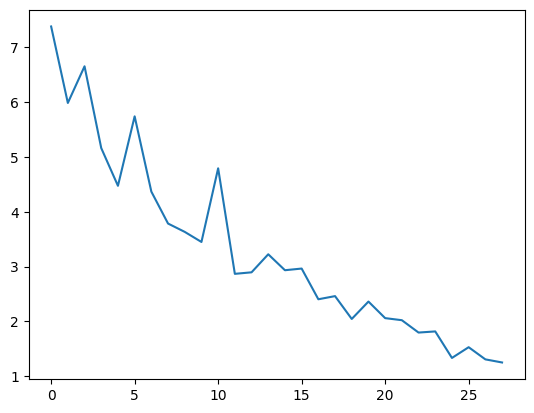

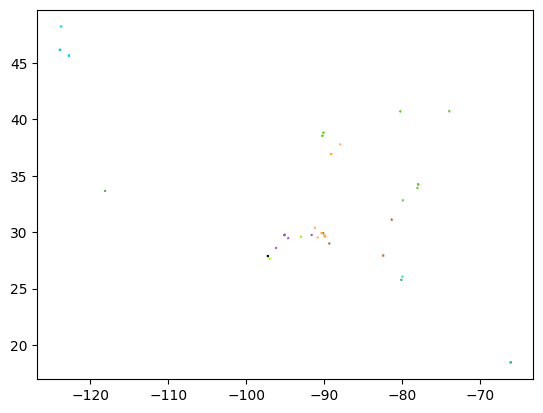

In [71]:
# 聚类，保存不同的sse
SSE = []
for i in range(2,30):
  kmeans = KMeans(n_clusters=i,Q=0.01,max_iter=150)
  kmeans.fit(distancemat)
  SSE.append(kmeans.sse)
#画图
plt.figure(0)
plt.plot(SSE)
plt.show()

#使用最好的结果进行聚类
n_clusters=12
kmeans = KMeans(n_clusters=n_clusters,Q=0.01,max_iter=150)
kmeans.fit(distancemat)
kmeans.sse  #输出sse
kmeans.labels_  #输出标签
kmeans.center_tra  #输出聚类中心

#画图，不同类的轨迹使用不同的颜色
plt.figure(1)
for i in range(n_clusters):
   for name in distancemat.columns[kmeans.labels_==i]:
        plt.plot(data[name].loc[:,'GPSLongitude'],data[name].loc[:,'GPSLatitude'],c=sns.xkcd_rgb[list(sns.xkcd_rgb.keys())[i]])
plt.show()

#保存每一个轨迹属于哪一类
kmeans_result = pd.DataFrame(columns=['label','id'])
for i in range(n_clusters):
   kmeans_result.loc[i] = [i,distancemat.columns[kmeans.labels_==i].tolist()]



In [65]:
def data_analysis():
  point_data_analysis()

data_analysis()

<ipython-input-64-5216bc77c6a1>:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['speed_enlarged'] = df1.apply(speed_Enlarge,axis=1)
<ipython-input-64-5216bc77c6a1>:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['calculated_speed_enlarged'] = df1.apply(Calculated_speed_enlarge,axis=1)


In [ ]:
# 本段代码在地图上标注数据点
import plotly.express as px
import pandas as pd

def AIS_point_plot():
  color_scale = [(0, 'orange'), (1,'red')]
  df = pd.read_csv('sample_data/smallaisdata.csv')
  fig = px.scatter_mapbox(df,
                        lat="LAT",
                        lon="LON",
                        hover_name="MMSI",
                        hover_data=["MMSI"],
                        color_continuous_scale=color_scale,
                        zoom=8,
                        height=800,
                        width=800)
  # 对数据点进行核密度分析


  fig.update_layout(mapbox_style="open-street-map")
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.show()
  # 后面要做的：将AIS数据点以MMSI为一条轨迹，用不同颜色将轨迹标注出来



AIS_point_plot()

In [ ]:
# 参考两篇论文处理漂移点和异常点
# 将K-means聚类做出来
# 在地图上标出轨迹， 并对其他指标进行分析